In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

import numpy as np
from astropy.nddata import CCDData
from astropy import units as u
from ccdproc import trim_image
from astropy.table import Table

# need to get import to work in notebook w/o global package install
import sys  
sys.path.append('..')
from apextract import extract
from identify import identify, identify_widget

In [2]:
lamp = '../../pydis_example/apo05/05may31.0035r.fits' # HeNeAr lamp

img = CCDData.read(lamp, unit=u.adu)
# put in units of ADU/s
img.data = img.data / (img.header['EXPTIME'])
img.unit = u.adu / u.s

# trim off bias section
img = trim_image(img, fits_section=img.header['DATASEC'])

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [3]:
# this data comes from the APO DIS red channel, which has wavelength axis backwards
# (despite not mentioning in the header)
wapprox = (np.arange(img.shape[1]) - img.shape[1]/2)[::-1] * img.header['DISPDW'] + img.header['DISPWC']

# flux = np.nanmean(img[500:525,:], axis=0) - np.nanmedian(img)

In [4]:
fake_trace = np.ones(img.shape[1]) * img.shape[0] / 2
flux, _,_ = extract(img, fake_trace, display=False)

../apextract.py:286: RuntimeWarning: invalid value encountered in sqrt
  (N_A + N_A**2. / N_B) * (sigB**2.))


In [5]:
# Easiest mode: previously ran identify, saved to output file
ww1 = identify(wapprox, flux, identify_mode='file', 
               previous_file='../../pydis_example/05may31.0035r.fits.lines', 
               fit_mode='spline')

# This is a form of "reidentify". 

Mode='file': 38 lines used from ../../pydis_example/05may31.0035r.fits.lines


In [6]:
# plt.plot(ww1, flux)

In [7]:
# a simple table of prominent HeNeAr lines for the instrument in question
apo_henear = Table.read('../../pydis_example/apohenear.dat', 
                        format='ascii', names=('wave',))

In [8]:
ww2 = identify(wapprox, flux, identify_mode='nearest', 
               fit_mode='spline', autotol=5, linewave=apo_henear['wave'])

Mode='nearest': 19 lines matched.


In [9]:
# a slight difference in the solution, really impacts near the edges of the data
# plt.plot(ww1, flux)
# plt.plot(ww2, flux)


    Instructions:
    ------------
    0) For proper interactive widgets, ensure you're using the Notebook backend
    in the Jupyter notebook, e.g.:
        %matplotlib notebook
    1) Click on arc-line features (peaks) in the plot. The Pixel Value box should update.
    2) Enter the known wavelength of the feature in the Wavelength box.
    3) Click the Assign button, a red line will be drawn marking the feature.
    4) When you've identified all your lines, stop the interaction for (or close) the figure.


<IPython.core.display.Javascript object>


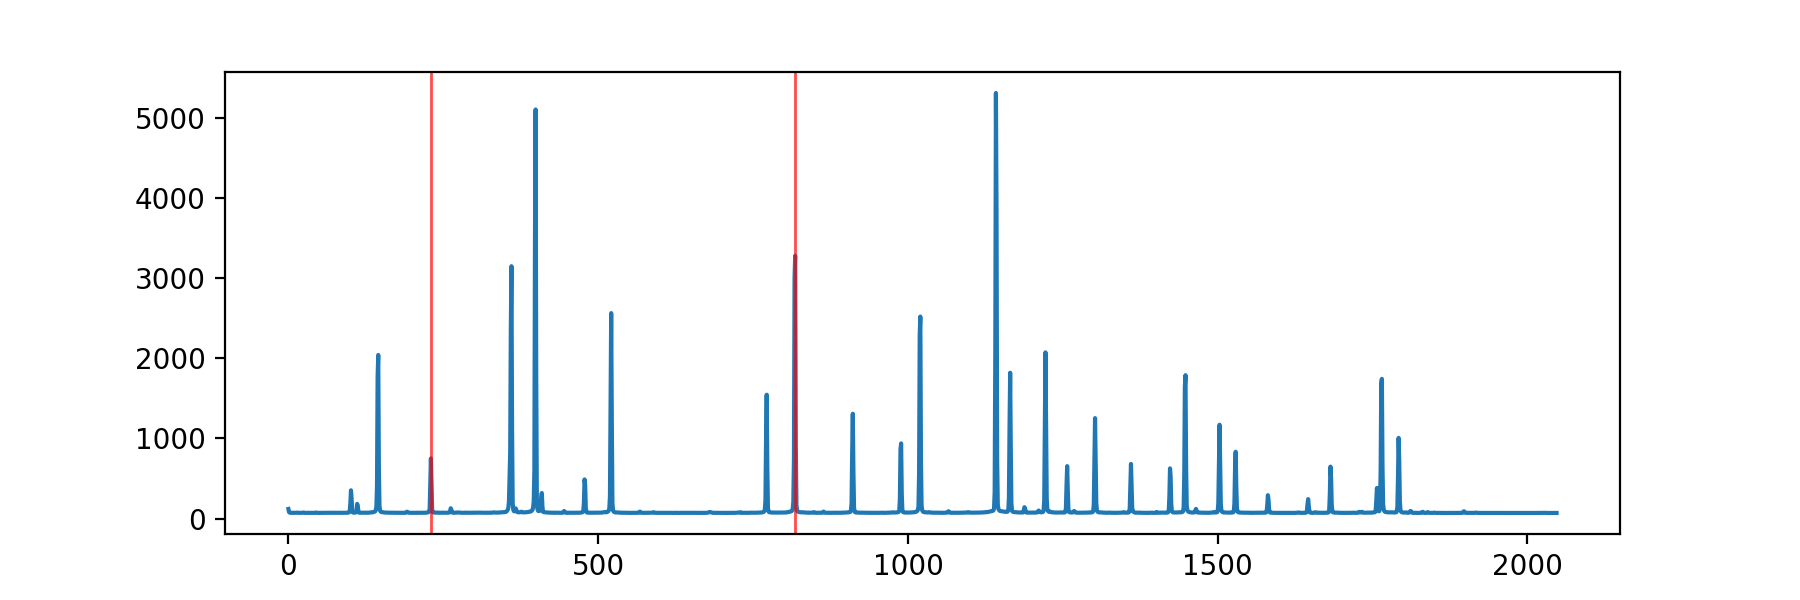

Output()

[230.00375554007613] ['2342']
[230.00375554007613, 817.5571916041685] ['2342', '23423453']


In [10]:
# This makes a nice GUI, but it doesn't return the variables like this... hmm...
xpl, wav = identify_widget(np.arange(len(flux)), flux)

In [15]:
print(xpl, wav)

[] []


<IPython.core.display.Javascript object>


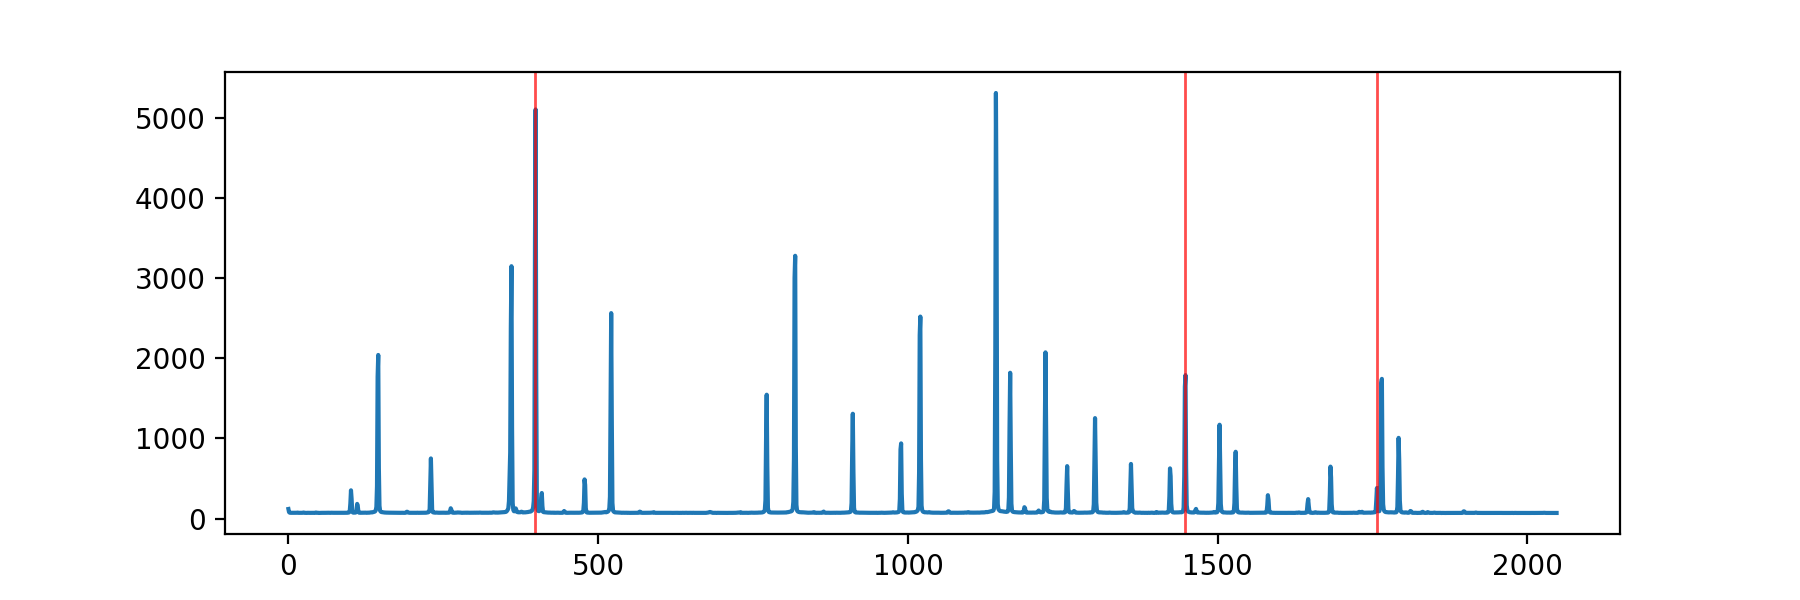

[398.7710836888384] ['23423']
[398.7710836888384, 1447.5693599691824] ['23423', '234231']
[398.7710836888384, 1447.5693599691824, 1757.132801495519] ['23423', '234231', '112']


In [17]:
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.optimize import curve_fit

def _gaus(x, a, b, x0, sigma):
    """
    Define a simple Gaussian curve

    Could maybe be swapped out for astropy.modeling.models.Gaussian1D

    Parameters
    ----------
    x : float or 1-d numpy array
        The data to evaluate the Gaussian over
    a : float
        the amplitude
    b : float
        the constant offset
    x0 : float
        the center of the Gaussian
    sigma : float
        the width of the Gaussian

    Returns
    -------
    Array or float of same type as input (x).
    """
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2)) + b

xpixels = np.arange(len(flux))

xpxl = []
waves = []

# Create widgets, two text boxes and a button
xval = widgets.BoundedFloatText(
    value=5555.0,
    min=np.nanmin(xpixels),
    max=np.nanmax(xpixels),
    step=0.1,
    description='Pixel Value (from click):',
    style={'description_width': 'initial'})

linename = widgets.Text(  # value='Enter Wavelength',
    placeholder='Enter Wavelength',
    description='Wavelength:',
    style={'description_width': 'initial'})

button = widgets.Button(description='Assign')

fig, ax = plt.subplots(figsize=(9, 3))

# Handle plot clicks
def onplotclick(event):
    # try to fit a Gaussian in the REGION (rgn) near the click
    rgn = np.where((np.abs(xpixels - event.xdata ) <= 5.))[0]
    try:
        sig_guess = 3.
        p0 = [np.nanmax(flux[rgn]), np.nanmedian(flux), event.xdata, sig_guess]
        popt, _ = curve_fit(_gaus, xpixels[rgn], flux[rgn], p0=p0)
        # Record x value of click in text box
        xval.value = popt[2]
    except RuntimeError:
        # fall back to click itself if that doesnt work
        xval.value = event.xdata
    return

fig.canvas.mpl_connect('button_press_event', onplotclick)

# Handle button clicks
def onbuttonclick(_):
    xpxl.append(xval.value)
    waves.append(linename.value)
    print(xpxl, waves)

    ax.axvline(xval.value, lw=1, c='r', alpha=0.7)
    return xpxl, waves

button.on_click(onbuttonclick)

# Do the plot
ax.plot(xpixels, flux)
plt.draw()

# Display widgets
display(widgets.HBox([xval, linename, button]))

In [18]:
xpxl

[398.7710836888384, 1447.5693599691824, 1757.132801495519]